In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
    
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [6]:
# Pandas kütüphanesi vasıtası ile veri setini yükleyelim
df = pd.read_csv('nyc-rolling-sales.csv')

In [7]:
# İlk 5 veriye ve şemasına genel bir göz gezdirelim.
pd.set_option('display.max_columns',999)
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [8]:
# Veride kaç satır ve kolon var?
df.shape

(84548, 22)

In [9]:
# Boş, kullanılmayan ve sales price tahminlemeye etkisi az olacak kolonları silebileriz.
del df['EASE-MENT']
del df['Unnamed: 0']
del df['SALE DATE']
del df['ADDRESS']
del df['APARTMENT NUMBER']

In [10]:
# Kolonların veri tiplerine göz gezdirelim
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 17 columns):
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
BUILDING CLASS AT PRESENT         84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GROSS SQUARE FEET                 84548 non-null object
YEAR BUILT                        84548 non-null int64
TAX CLASS AT TIME OF SALE         84548 non-null int64
BUILDING CLASS AT TIME OF SALE    84548 non-null object
SALE

In [11]:
# Kolonların veri tiplerini veri sözlüğü dolayısıyla biliyoruz. 
# Uygun veri tiplerine çevrim yaparak işlemlemrimizi daha doğru şekilde gerçekleştirebiliriz.

df['BOROUGH'] = df['BOROUGH'].astype('category')
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].astype('category')
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['BLOCK'] = df['BLOCK'].astype('category')
df['LOT'] = df['LOT'].astype('category')
df['BUILDING CLASS AT PRESENT'] = df['BUILDING CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['BUILDING CLASS AT TIME OF SALE'] = df['BUILDING CLASS AT TIME OF SALE'].astype('category')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

In [12]:
# Tekrar göz gezdirdiğimizde tüm kolonların tiplerinin istediğimiz gibi olduğunuz görebiliriz.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 17 columns):
BOROUGH                           84548 non-null category
NEIGHBORHOOD                      84548 non-null category
BUILDING CLASS CATEGORY           84548 non-null category
TAX CLASS AT PRESENT              84548 non-null category
BLOCK                             84548 non-null category
LOT                               84548 non-null category
BUILDING CLASS AT PRESENT         84548 non-null category
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  58296 non-null float64
GROSS SQUARE FEET                 56936 non-null float64
YEAR BUILT                        84548 non-null int64
TAX CLASS AT TIME OF SALE         84548 non-null category
BUILDING CLASS AT TIME OF SALE    8454

In [13]:
# Sayısal değişkenlerin bazı açıklayıcı istatistiklerine genel bir göz atalım.
numeric_data=df.select_dtypes(include=[np.number])

numeric_data.describe(include='all')

,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,84548.000000,84548.000000,84548.000000,84548.000000,5.829600e+04,5.693600e+04,84548.000000,6.998700e+04
mean,10731.991614,2.025264,0.193559,2.249184,3.941676e+03,4.045707e+03,1789.322976,1.276456e+06
std,1290.879147,16.721037,8.713183,18.972584,4.198397e+04,3.503249e+04,537.344993,1.140526e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,10305.000000,0.000000,0.000000,1.000000,1.650000e+03,1.046750e+03,1920.000000,2.250000e+05
50%,11209.000000,1.000000,0.000000,1.000000,2.325000e+03,1.680000e+03,1940.000000,5.300000e+05
75%,11357.000000,2.000000,0.000000,2.000000,3.500000e+03,2.560000e+03,1965.000000,9.500000e+05
max,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


Aşağıdaki link ile veri sözlüğüne bakabiliriz.
https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf

Bu istatistiki verilere göre;

- ZIP CODES alanın 0 olan değerler var, muhtemelen yanlışlar.
- COMMERCIAL UNITS alanın 75%'i boş.
- TOTAL UNIT alanının %50'si 1 olarak geçiyor. Ne anlaama geldiğini bilmiyoruz.
- SQUARE FEET alanlarının %20 civarında verisi eksik.
- YEAR BUILT alanında 0 değerler var, buradaki veride de bozukluklar olduğu belli.
- Veri sözlüğünde SALE PRICE'i 0 olanların miras ile geçtiği veya mal varlığı aktarımı olduğunu biliyoruz. Bunları da dikkate almak gerek.
- Veri sözlüğünü incelediğimizde SALE_DATE, ADDRESS, APARTMENT NUMBER  gibi alanlara ihtiyacımız olmayacağını öngörebiliriz.

In [17]:
# Şimdi kategorik verilere bakalım
cat_data=df.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,84548,84548,84548,84548,84548,84548,84548,84548,84548
unique,5,254,47,11,11566,2627,167,4,166
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,5066,1,D4,1,R4
freq,26736,3068,18235,38633,404,4125,12663,41533,12989


Kategorik verilerin unique değerlerine baktığımızda 3 tane alanı kullanabileceğimizi görüyoruz. NEIGHBORDHOOD alanını kullanabilsek çok güzel olurdu fakat veri sayısının azlığından dolayı işe yaramayacaktır. (35k/247) 

- BOROUGH
- BUILDING CLASS CATEGORY
- TAX CLASS AT PRESENT

Veri sözlüğü ve genel emlak ile ilgili bilgilerini değerlendirdiğimizde emlak fiyatına en büyük etkenlerin aşağıdaki alanlar olacağını tahmin edebiliriz. Bu alanları dikkate alarak verimizi incelemeye ve düzenlemeye devam edebiliriz.

- Emlak büyüklüğü
- Emlak konumu(ilçe, mahalle vs.)
- Emlak yaşı

In [18]:
# Mükerrer kayıtları tespit et
sum(df.duplicated(df.columns))

2871

In [19]:
# Mükerrer kayıtları sil
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [20]:
#NULL verisi olan kolonlara bakalım
df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [21]:
miss = df.isnull().sum()/len(df)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.162592
LAND SQUARE FEET     0.305325
GROSS SQUARE FEET    0.321155
dtype: float64

In [22]:
# Bu iki alanın boş değerlerini ortalaması ile doldurabiliriz.
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean());
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean());

In [23]:
# SALE_PRICE alanının boş ve 0 olan verilerini işlem kümemizden çıkaralım.
df = df[df['SALE PRICE'].notnull() & df['SALE PRICE'] > 0];

df.shape

(58865, 17)

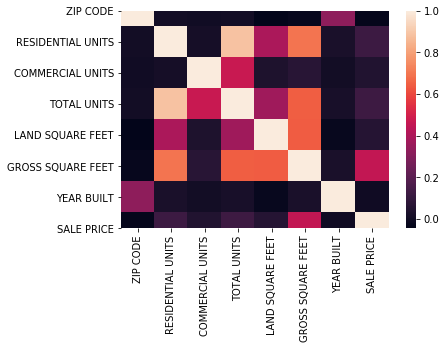

In [24]:
# Sayısal kolonların korelasyon grafiğine bakalım
corr = numeric_data.corr()
sns.heatmap(corr)

In [25]:
# Sayısal verilerin korelasyonuna baktığımızda en büyük etkenin gross square feet olduğunu görebiliyoruz.
# Sayısal kolonların satış fiyatına göre korelasyonunu sıralayalım.
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.455423
TOTAL UNITS          0.125101
RESIDENTIAL UNITS    0.119698
LAND SQUARE FEET     0.060183
COMMERCIAL UNITS     0.046006
YEAR BUILT          -0.003539
ZIP CODE            -0.034170
Name: SALE PRICE, dtype: float64

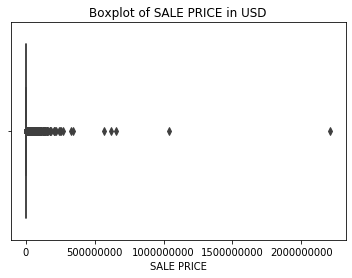

In [26]:
# Şimdi aykırı değerleri belirleyip temizleyelim
plt.figure()

sns.boxplot(x='SALE PRICE',data=df)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

Grafik ve istatistiki değerlere göre, emlakların;

- %75'i 1 milyon dolar civarında
- %25'i ise 300 bin dolar civarında.

Bu verilere göre 100 bin dolar ile 3 milyon dolar arasındaki verileri baz alabiliriz.

In [27]:
data = df[(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 3000000)]
len(data)

52070

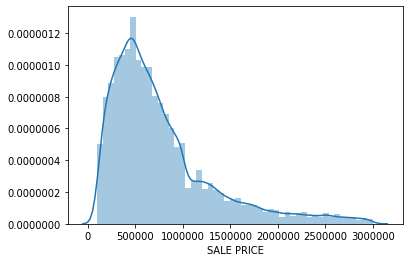

In [28]:
sns.distplot(data['SALE PRICE'])

In [29]:
# Satış fiyatının biraz sağa eğrik olduğunu görebiliriz. Normalizasyon yaparken dikkat edilmesi gerekli
data['SALE PRICE'].skew()

1.596806032661124

In [30]:
# YEAR BUILT 0 olan verilerini işlem kümemizden çıkaralım.
print(len(df[df['YEAR BUILT'] > 0]))
df = df[df['YEAR BUILT'] > 0];

df.shape

54581


(54581, 17)

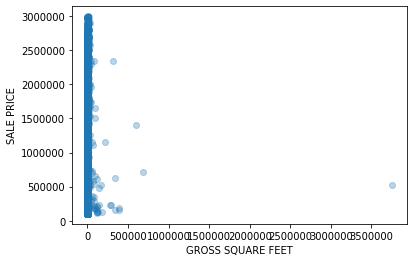

In [31]:
# Korelasyonda satış fiyatına en çok etki eden diğer veriler ile devam edebiliriz.
plt.figure()
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})

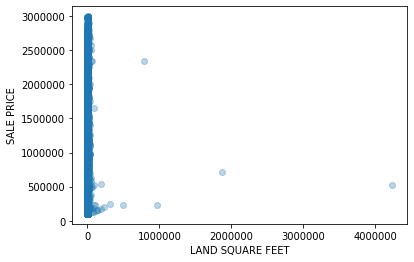

In [32]:
plt.figure()
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})

İstatistki verilere göre square feet'lerin %75'i 3000'den az, maksimum değer ise 3 milyon. 4000 ve 15 000 aralığındaki verilerin dağılıma bakabiliriz.

1251


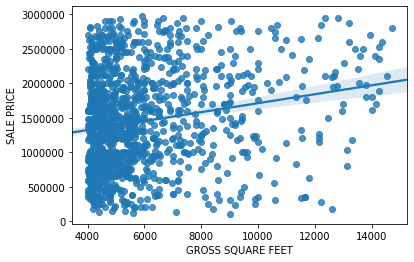

In [33]:
grossData = data[(data['GROSS SQUARE FEET'] > 4000) & (data['GROSS SQUARE FEET'] < 15000)]
print(len(grossData))
plt.figure()
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=grossData)

In [34]:
# Dağılımın normal olduğunu görebiliyoruz. 15000'in üstündeki verileri kümeden çıkarabiliriz.
data = data[data['GROSS SQUARE FEET'] < 15000]

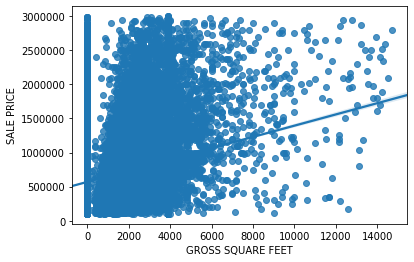

In [35]:
# Grafiklere tekrar bakalım

plt.figure()
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data)

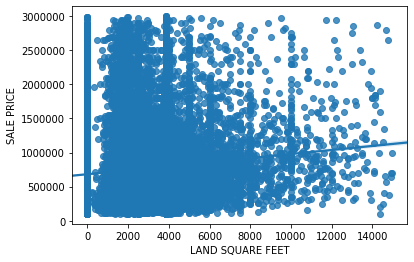

In [39]:
plt.figure()
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=data)

In [40]:
# LAND SQAURE FEET alanında bazı aykırı değerler kalmış, grafiğe baktığımızda yine 15 0000 altındakileri almamızın yeterli olacağını görebiliyoruz.
data = data[data['LAND SQUARE FEET'] < 15000]

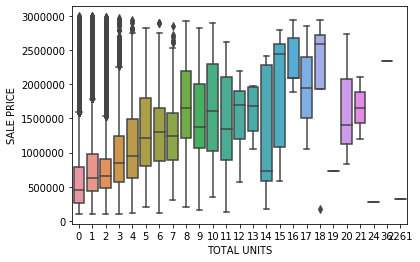

In [41]:
plt.figure()
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=data)
plt.show()

In [42]:
data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,23744
0,0,14536
2,2,9438
3,3,2678
4,4,646
6,6,344
5,5,161
8,8,103
7,7,61
9,9,43


In [43]:
# Total units'de bulunan aykırı değerleri de çıkarabiliriz
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] != 2261)]

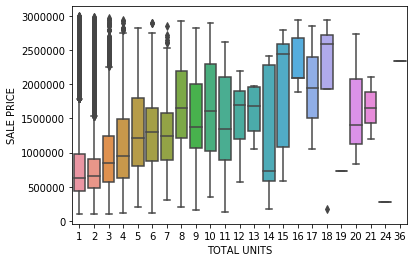

In [44]:
# Aykırı değerleri çıkardıktan sonra verileri tekrar kontrol edelim
plt.figure()
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=data)
plt.show()

In [45]:
# Numerik verileri temizlediğimizde elimizde 35k veri kaldığını görebiliyoruz.
len(data)

37322

In [46]:
pivot=data.pivot_table(index='BOROUGH', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
BOROUGH,
1,1245000.0
2,455000.0
3,840000.0
4,635000.0
5,475000.0


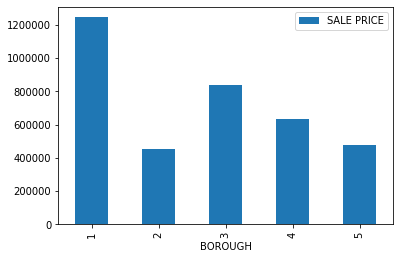

In [47]:
pivot.plot(kind='bar')

Veri hakkında araştırdığımda ilçe id'lerinin karşılıklarını bu şekilde tespit ettik. En pahalı emlakların manhattan'da olması gayet doğal. Grafiklerin de bunu doğruladığını görebiliyoruz.

- 1: Manhattan
- 2: Bronx
- 3: Brooklyn
- 4: Queens
- 5: Staten Island

In [48]:
print(data['BUILDING CLASS CATEGORY'].nunique())

pivot=data.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot

38


,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,510000.0
02 TWO FAMILY DWELLINGS,660000.0
03 THREE FAMILY DWELLINGS,800000.0
04 TAX CLASS 1 CONDOS,420000.0
05 TAX CLASS 1 VACANT LAND,649500.0
06 TAX CLASS 1 - OTHER,500000.0
07 RENTALS - WALKUP APARTMENTS,1200000.0
08 RENTALS - ELEVATOR APARTMENTS,2820000.0
09 COOPS - WALKUP APARTMENTS,282000.0


In [49]:
# Vergi sınıfına göre orta değerlerine bakalım
pivot = data.pivot_table(index='TAX CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT PRESENT,
1,590000.0
1A,390000.0
1B,631213.0
1C,931698.0
2,920000.0
2A,1105800.0
2B,1450000.0
2C,799000.0
4,975000.0


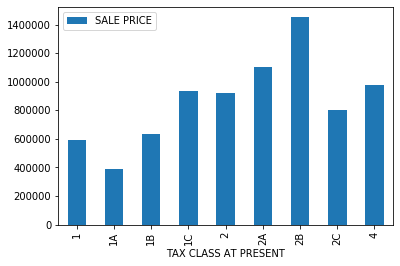

In [50]:
pivot.plot(kind='bar')

In [51]:
pivot=data.pivot_table(index='TAX CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,580000.0
2,930000.0
4,975000.0


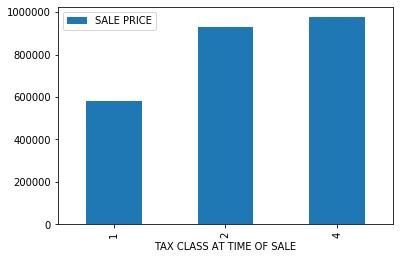

In [52]:
pivot.plot(kind='bar')

Grafiğe baktığımızda en pahalı evlerin Manhattan'da olduğunu görebiliyoruz